# Code for Implementing LightGBM

***

This file implements code for forecasting with LGBM.

It also illustrates the steps for forecasting using `sktime`.

Note that this code follows the tutorial given [here](https://www.sktime.org/en/stable/examples/01_forecasting.html) so credit should be given to the `sktime` authors.

***

# General `sktime` Forecasting Steps

### Step 1: Preparation of the Data

In [25]:
# example dataset
from sktime.datasets import load_airline
# nice plotting function
from sktime.utils.plotting import plot_series
# working with integers and arrays
import numpy as np
# naive forecasting model
from sktime.forecasting.naive import NaiveForecaster
# k neighbors regressor
from sklearn.neighbors import KNeighborsRegressor
# data reduction for regressions or trees
from sktime.forecasting.compose import make_reduction

In [2]:
# example airline passenger data
y = load_airline()

In [3]:
# first few rows of x
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

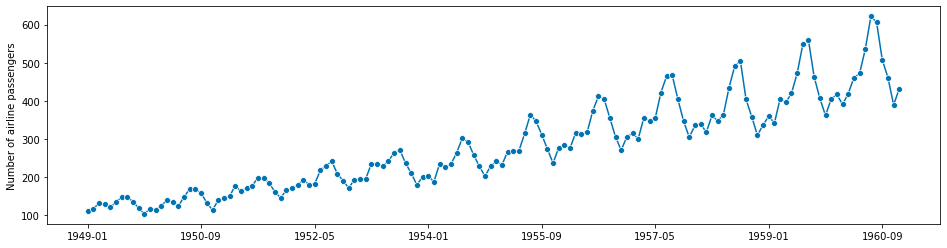

In [4]:
# nice plot
plot_series(y)

***

### Step 2: Specify the Forecast Horizon

In [5]:
# use a numpy.array of integers to index the time points or periods ahead which we want to forecast
# remember this is end exclusive and relative to the latest observed time point
fh = np.arange(1, 21)

***

### Step 3: Specify the Forecasting Algorithm

All `sktime` forecast models use the same interface, so the previous and following steps will be the same no matter the method chosen.

In [6]:
# forecasting using the last observed value
forecaster = NaiveForecaster(strategy = "last")

### Step 4: Fit the Forecasting Model to the Observed Data

In [7]:
# fit the model to the data
forecaster.fit(y)

NaiveForecaster()

### Step 5: Generate Forecasts

In [8]:
# generate forecasts
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

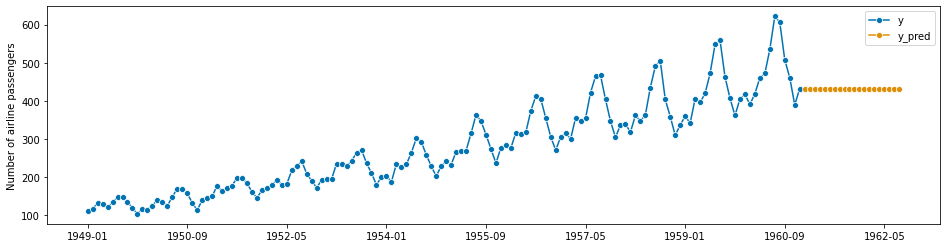

In [9]:
# plot observed and forecasted points
plot_series(y, y_pred, labels = ["y", "y_pred"])

***
***

# Adding a Train-Test Split

In [10]:
# train-test split function for temporal data
from sktime.forecasting.model_selection import temporal_train_test_split

In [11]:
# x_test contains the data we are attempting to forecast - x_train contains the data up to that point
y_train, y_test = temporal_train_test_split(y, test_size = len(fh))

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

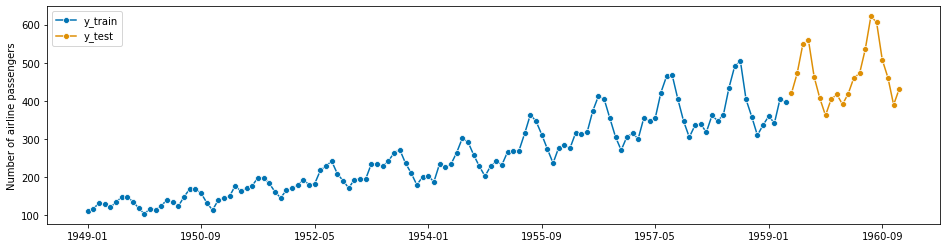

In [12]:
# plot train and test data together
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [13]:
# fit model to observed data
forecaster.fit(y_train)

NaiveForecaster()

In [14]:
# generate forecasts
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

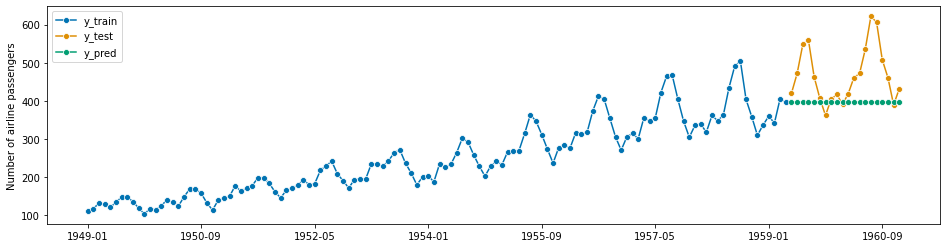

In [15]:
# plot train, test, and forecast data
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

***
***

# Specify a Forecasting Metric and Evaluate on Test Data

In [20]:
# import mean absolute error and mean squared error metrics (specify square root in function)
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

In [23]:
# MAE - first argument is meant to be actual values, second forecasted
mean_absolute_error(y_test, y_pred)

76.0

In [24]:
# RMSE - first argument is meant to be actual values, second forecasted
mean_squared_error(y_test, y_pred, square_root=True)

101.35728883509069

***
***

# Advanced Composition Patterns - Reduction

Some forecasting models, such as regression models or LGBM, require data to be formatted in a feature/label tabulation.

The `make_reduction` function is used to structure the data appropriately for these types of models. You supply the forecasting model, the window length, and the reduction strategy.

In [26]:
# regression model
regressor = KNeighborsRegressor(n_neighbors=1)

In [27]:
# construct the forecasting model with reduced data
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

In [28]:
# fit the forecasting model
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=1),
                                     window_length=15)

In [29]:
# make forecasts
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

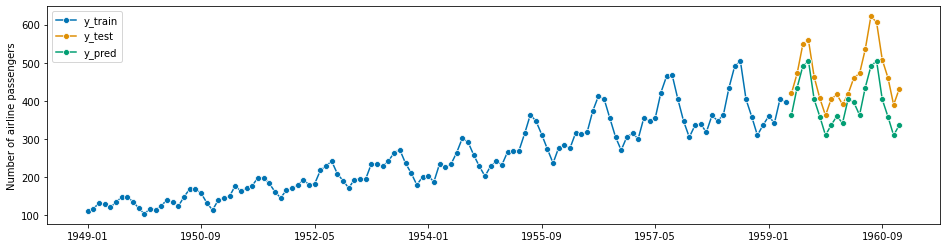

In [30]:
# plot train, test, and forecasts
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [31]:
# MAE
mean_absolute_error(y_test, y_pred)

71.9

In [32]:
# RMSE
mean_squared_error(y_test, y_pred, square_root=True)

77.40413425651113

***
***

# Optimizing Parameters Using Cross-Validation

`sktime` provides parameter tuning strategies using `compositors` (composites of forecasters and tuning parameters?). `ForecastingGridSearchCV` is constructed with:

* a forecaster to tune
* a cross-validation constructor
* a `scikit-learn` parameter grid
* tuning strategy parameters

In [34]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

In [35]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

In [36]:
# specify window_length parameters to test
param_grid = {"window_length": [7, 12, 15]}

In [37]:
# We fit the forecaster on an initial window which is 80% of the historical data
# Then use temporal sliding window cross-validation to find the optimal hyper-parameters

# window_length is the length of training data in a fold
# fh is 1 by default - train on window of 20, predict one step ahead
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)

In [38]:
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)

In [39]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=99, window_length=20),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                                                        window_length=15),
                        param_grid={'window_length': [7, 12, 15]})

In [40]:
y_pred = gscv.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

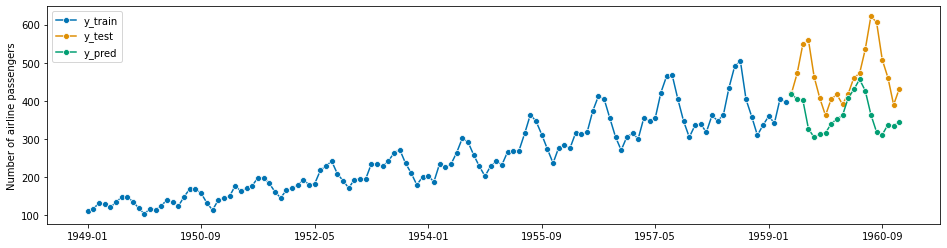

In [41]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [44]:
# MAE
mean_absolute_error(y_test, y_pred)

103.66999999999999

In [45]:
# RMSE
mean_squared_error(y_test, y_pred, square_root=True)

132.48072312604577

In [46]:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=7)

***
***

# Test LGBM Regressor

In [47]:
import lightgbm as lgb

In [48]:
regressor = lgb.LGBMRegressor()

In [78]:
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

In [79]:
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(), window_length=5)

In [80]:
# make forecasts
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

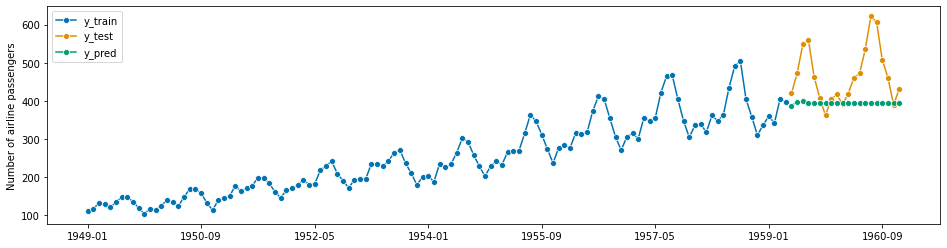

In [81]:
# plot train, test, and forecasts
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [82]:
# MAE
mean_absolute_error(y_test, y_pred)

76.76641240754444

In [83]:
# RMSE
mean_squared_error(y_test, y_pred, square_root=True)

101.81913910418542

In [42]:
# import weekly finance series, skipping column names
ts = np.genfromtxt("../../../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

In [43]:
x = ts[0,:]

In [18]:
x.shape

(247,)

In [19]:
plot_series(x)

TypeError: input must be a one of (<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>), but found type: <class 'numpy.ndarray'>

In [ ]:
regressor = KNeighborsRegressor(n_neighbors = 1)

In [ ]:
forecaster = make_reduction(regressor, window_length = 5, strategy = 'recursive')